# SmartChurn: Predicting Customer Churn & Understanding Why Customers Leave
---

## 1. Overview

Retaining customers is more profitable than acquiring new ones.
The SmartChurn project helps energy companies predict which customers are likely to leave — and more importantly, why.

By combining predictive modeling with explainable AI, SmartChurn moves businesses from reactive churn control to proactive customer retention.
The model identifies at-risk customers early, uncovers the behavioral and contractual reasons behind churn, and supports data-driven retention strategies that are both efficient and cost-effective.

### Objectives
- Build a churn prediction model that can detect minority churners effectively.
- Identify the behavioral and contractual factors most associated with churn.
- Provide interpretable insights to support strategic retention actions.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
%matplotlib inline

## 2. Load Data

The dataset combines both behavioral attributes (such as usage and consumption) and contractual information (such as tariff type, acquisition channel, and renewal history).
This creates a comprehensive customer profile for understanding churn behavior.

In [2]:
# Load dataset
df = pd.read_csv('data_for_predictions.csv')

In [3]:
# Drop redundant columns
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Ensure 'id' column exists
if 'id' not in df.columns:
    df['id'] = df.index.astype(str)

In [4]:
print('Dataset shape:', df.shape)
display(df.head(3))

Dataset shape: (14606, 63)


,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.0,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.0,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.0,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0


In [5]:
# Feature selection
# Target
y = df['churn']

# Features: drop id & churn
X = df.drop(columns=['churn', 'id'])

In [6]:
# Encode categorical features
from sklearn.preprocessing import LabelEncoder

for col in X.select_dtypes('object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

In [7]:
print('Feature matrix shape:', X.shape)
print('Churn proportion: {:.2%}'.format(y.mean()))

Feature matrix shape: (14606, 61)
Churn proportion: 9.72%


The churn rate is only ~9.7%, making this a highly imbalanced dataset — a key challenge for churn prediction.

## 3. Modeling Approach: XGBoost + SMOTE

Because churners represent a small minority, standard models would tend to ignore them.
To address this, SmartChurn uses a robust pipeline that balances the data and models non-linear behavior effectively.
- **SMOTE:** Oversamples minority churners to ensure balanced training.
- **XGBoost:** Captures complex feature interactions and handles imbalance robustly.
- **Stratified K-Fold CV:** Preserves churn ratio across folds for reliable performance.

We focus on recall (catching churners) over raw accuracy — because missing a churner means lost revenue.

In [8]:
# Cross-Validation Random Forest + SMOTE
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_prob = np.zeros(len(X))
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': 0.0})

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Handle imbalance
    X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

    # XGBoost model
    xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42,
                        scale_pos_weight=(y_res.value_counts()[0] / y_res.value_counts()[1]), use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_res, y_res)

    # Store probabilities
    oof_prob[val_idx] = xgb.predict_proba(X_val)[:, 1]
    feat_imp['importance'] += xgb.feature_importances_

# Evaluate at default threshold 0.5
y_oof_pred_default = (oof_prob >= 0.5).astype(int)
print("Classification Report (threshold=0.5):")
print(classification_report(y, y_oof_pred_default, zero_division=0))

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     13187
           1       0.56      0.15      0.24      1419

    accuracy                           0.91     14606
   macro avg       0.74      0.57      0.59     14606
weighted avg       0.88      0.91      0.88     14606



**At default threshold (0.5):**
- Accuracy: 91%
- Recall (churners caught): 15%

Although the model predicts correctly overall, it misses most churners — making it ineffective for proactive action.

## 4. Threshold Optimization — Finding the Right Alert Level

To make predictions actionable, we tune the probability threshold using the Precision–Recall trade-off to maximize F1-score.
This balances recall (catching churners) with precision (avoiding false alarms).

In [9]:
# Threshold optimization based on precision-recall / F1
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y, oof_prob)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
opt_thr = thr[np.nanargmax(f1)] if len(thr) > 0 else 0.5
print(f"\nOptimal threshold: {opt_thr:.2f}")


Optimal threshold: 0.24


In [10]:
# evaluation with tuned threshold
y_oof_pred_tuned = (oof_prob >= opt_thr).astype(int)
print("\nClassification Report (tuned threshold):")
print(classification_report(y, y_oof_pred_tuned, zero_division=0))


Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     13187
           1       0.32      0.33      0.33      1419

    accuracy                           0.87     14606
   macro avg       0.62      0.63      0.63     14606
weighted avg       0.87      0.87      0.87     14606



In [11]:
from sklearn.metrics import roc_auc_score
print("ROC-AUC:", roc_auc_score(y, oof_prob))

ROC-AUC: 0.699065692059144


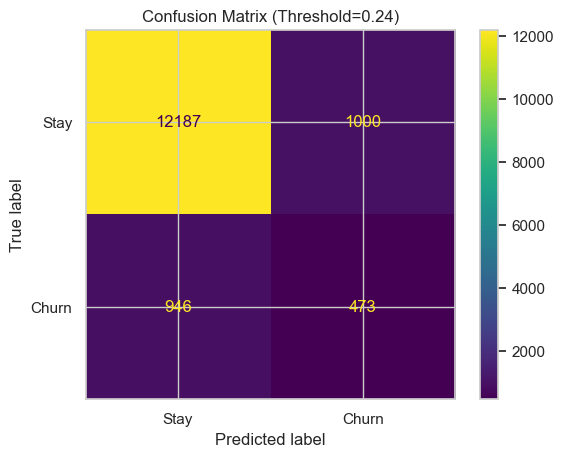

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, y_oof_pred_tuned, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=['Stay','Churn']).plot()
plt.title(f"Confusion Matrix (Threshold={opt_thr:.2f})")
plt.show()

**After tuning:**

- Recall improved from 0.15 → 0.33
- ROC-AUC: 0.70
- Accuracy: ~87%

> This means the model can now correctly identify around 473 out of 1,419 actual churners — nearly three times more than before — without heavily compromising precision.

## 5. Feature Importance — What Drives Churn?

XGBoost’s feature importance reveals which factors most strongly influence churn behavior.

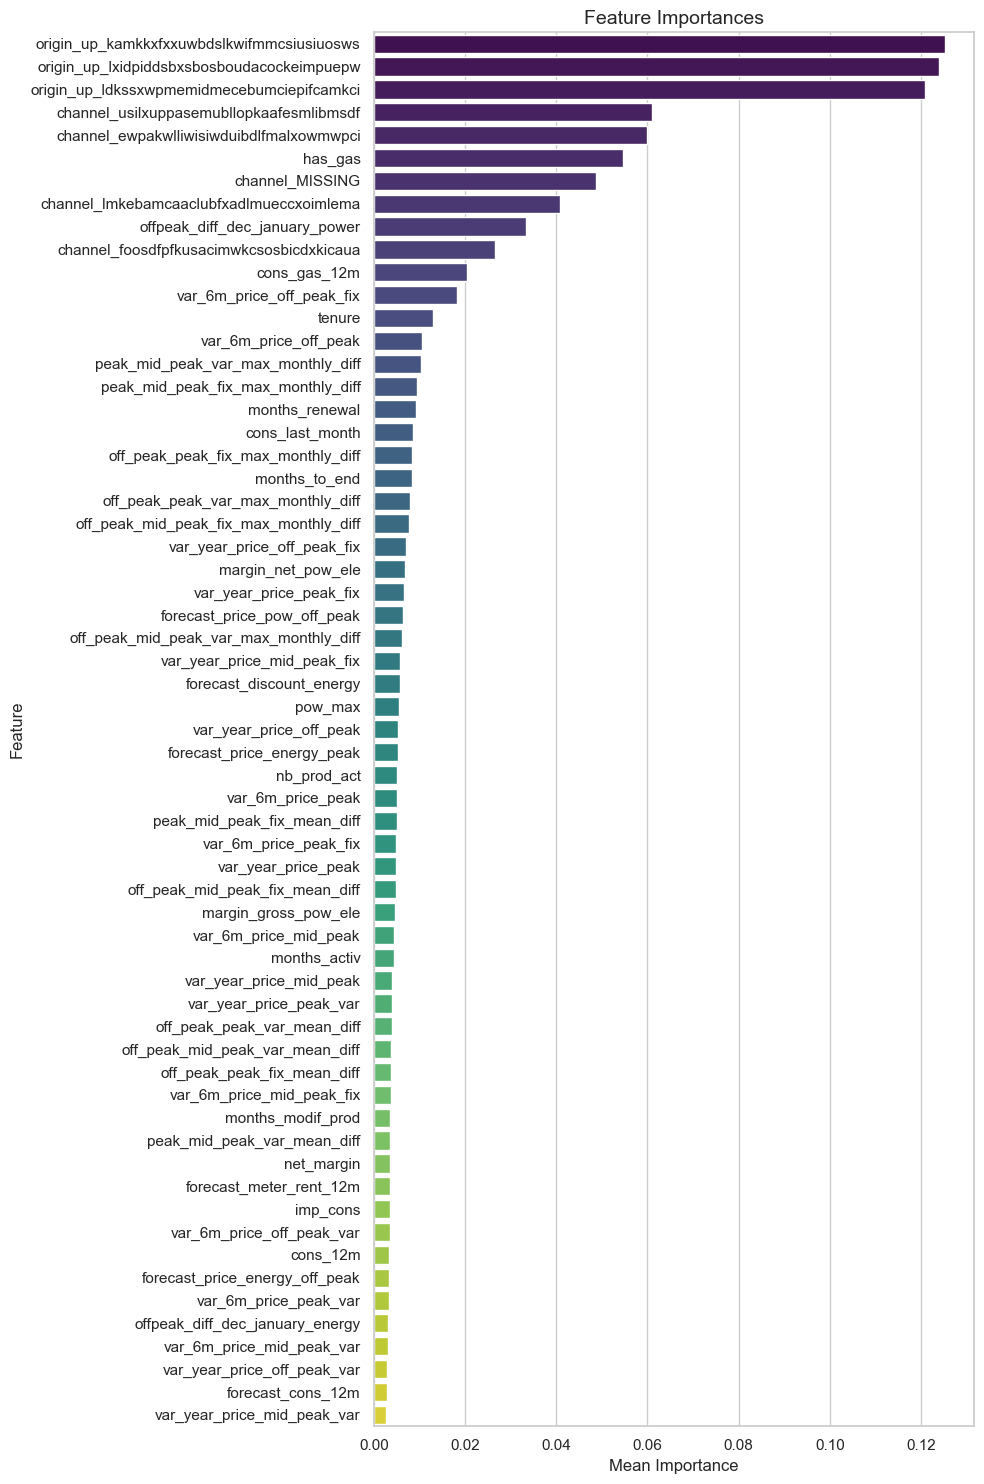

In [13]:
# Feature Importance
feat_imp['importance'] /= kf.get_n_splits()
feat_imp_sorted = feat_imp.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(data=feat_imp_sorted, x='importance', y='feature', hue='feature', palette='viridis', legend=False)
plt.title("Feature Importances", fontsize=14)
plt.xlabel("Mean Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

| Feature Group | Description | Influence |
|---------------|-------------|-----------|
| `origin_up_*` | Contract type / acquisition source | Strong |
| `channel_*` | Customer engagement / sales channel | Strong |
| `offpeak_diff_*` | Changes in off-peak usage | Moderate |
| `price_*` | Price or rate variation | Weak |
| `tenure`, `renewal` | Contract duration | Moderate |

Churn is influenced more by engagement and contract experience than by pricing.
This suggests retention efforts should focus on improving customer interaction and renewal experience, rather than relying solely on discounts.

## 6. Final Model
We retrain the model using the entire dataset with SMOTE balancing to finalize the churn predictor.

In [14]:
X_res_full, y_res_full = SMOTE(random_state=42).fit_resample(X, y)
xgb_final = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42,
                          scale_pos_weight=(y_res_full.value_counts()[0] / y_res_full.value_counts()[1]), use_label_encoder=False, eval_metric='logloss')
xgb_final.fit(X_res_full, y_res_full)

# Predict churn probability on full data
df["churn_prob_base"] = xgb_final.predict_proba(X)[:, 1]
print("Final model trained on all data.")
display(df[['id', 'churn_prob_base']].head())

Final model trained on all data.


,id,churn_prob_base
0,24011ae4ebbe3035111d65fa7c15bc57,0.885252
1,d29c2c54acc38ff3c0614d0a653813dd,0.052448
2,764c75f661154dac3a6c254cd082ea7d,0.040841
3,bba03439a292a1e166f80264c16191cb,0.027355
4,149d57cf92fc41cf94415803a877cb4b,0.050335


## 7. SHAP Analysis — Explaining the Predictions

To ensure transparency, we use **SHAP (SHapley Additive Explanations)** to interpret how each feature contributes to churn risk.

In [15]:
X_sample = X.sample(500, random_state=42)

booster = xgb_final.get_booster()
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP shape: {shap_values.shape}, X_sample: {X_sample.shape}")

SHAP shape: (500, 61), X_sample: (500, 61)


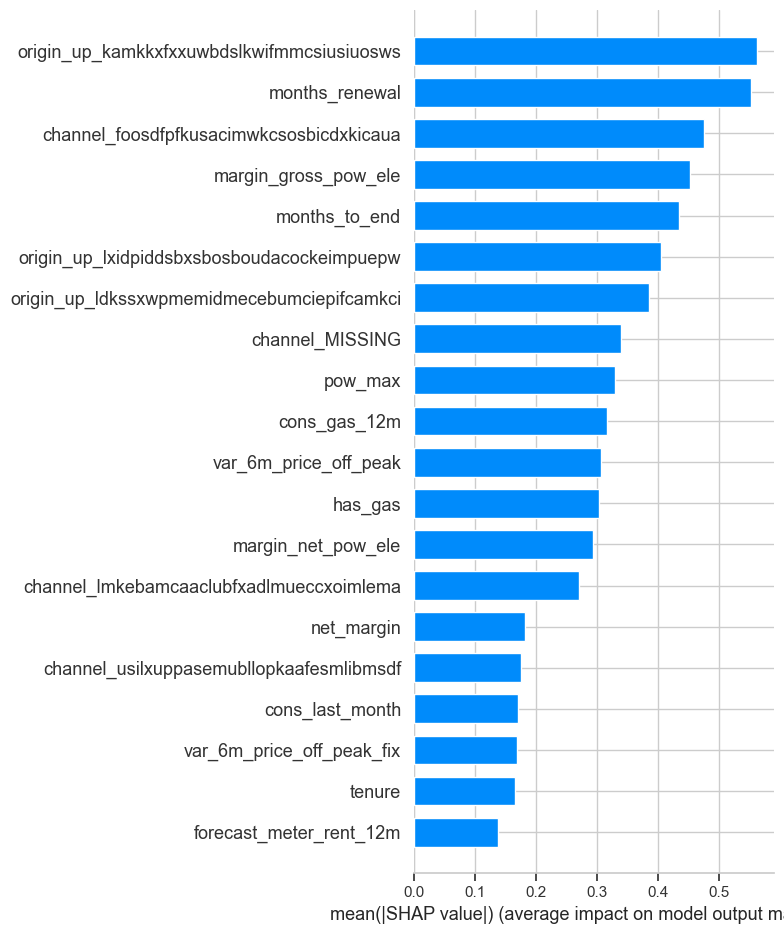

In [16]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

| **Feature Group** | **Feature(s)** |  **Influence** |
|--------------------|----------------|----------------|
| Contract Type & Origin | `origin_up_*` | **Strong** |
| Customer Tenure | `months_renewal` | **Strong** |
| Engagement Channels | `channel_foosdfpfkusacimwkcsosbicdxkicaua`, `channel_MISSING` | **Moderate** |
| Pricing & Margin | `margin_gross_pow_ele` | **Moderate** |
| Contract Expiry | `months_to_end` | **Moderate** |
| Consumption | `cons_gas_12m`, `pow_max` | **Weak–Moderate** |

Customers who joined through specific channels or have short renewal histories are more prone to churn.
Engagement and contract experience outweigh price factors — highlighting the need to personalize communication and strengthen post-renewal touchpoints.

In [17]:
import joblib, os
save_dir = "SmartChurn/results"
os.makedirs(save_dir, exist_ok=True)

df.to_csv(os.path.join(save_dir, "churn_base_results.csv"), index=False)
X.to_csv(os.path.join(save_dir, "X_features.csv"), index=False)
joblib.dump(xgb_final, os.path.join(save_dir, "xgb_final_model.pkl"))
np.save(os.path.join(save_dir, "shap_base.npy"), shap_values)

print("Notebook 1 completed & results saved to SmartChurn/results/")

Notebook 1 completed & results saved to SmartChurn/results/


## Reference

- [BCG Data Science Virtual Experience (The Forage)](https://www.theforage.com/simulations/bcg/data-science-ccdz)